In [237]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import random, os
import seaborn as sns
from glob import glob 
from PIL import Image
import cv2
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report

In [238]:
#Import metadata 
df =pd.read_csv('HAM10000_metadata.csv')

## Simple EDA

In [239]:
df.head(25)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


Text(0.5, 1.0, 'Frequency Distribution of Classes')

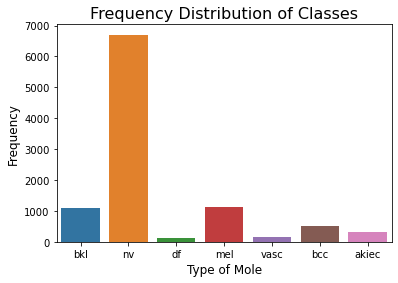

In [240]:
##Frequency distribution of classes:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [241]:
path = "HAM10000_images/"

In [242]:
df.shape

(10015, 7)

In [243]:
#Check for duplicates in dataset and remove them

bool_series = df['lesion_id'].duplicated()
bool_series.sum()

2545

In [244]:
#Removing duplicated 
df.drop_duplicates(subset ="lesion_id",
                     keep = "first", inplace = True)

In [245]:
df.shape

(7470, 7)

Text(0.5, 1.0, 'Frequency Distribution of Classes')

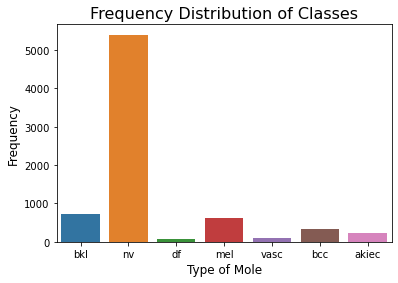

In [246]:
##Frequency distribution of classes after dropping duplicates:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [247]:
y.value_counts()

dx   
df       5403
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
dtype: int64

In [248]:
#Adding name of image to dataset
df["image_name"] = df['image_id']+ '.jpg'
X = df[["image_name",'dx', 'lesion_id']]
y = X.pop('dx').to_frame()

In [249]:
X.sample(5)

,image_name,lesion_id
8546,ISIC_0026592.jpg,HAM_0001406
6589,ISIC_0030738.jpg,HAM_0004560
2825,ISIC_0024949.jpg,HAM_0005669
8135,ISIC_0030232.jpg,HAM_0005092
5803,ISIC_0028620.jpg,HAM_0000939


In [250]:
y.value_counts()

dx   
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
dtype: int64

### Oversampling for imbalanced dataset

In [251]:
#TODO try to achieve a balanced dataset here!!
#undersample = RandomUnderSampler(sampling_strategy='majority')
sampling_strategy = {'bkl': 600, 'nv':2000 , 'df': 73, 'mel':500 , 'vasc':98 , 'bcc':327 , 'akiec':228 }
#undersample = RandomUnderSampler(sampling_strategy='majority')
#undersample = RandomUnderSampler(sampling_strategy= sampling_strategy)
oversample = RandomOverSampler(sampling_strategy='minority')
X,y  = oversample.fit_resample(X,y)
#X,y = undersample.fit_resample(X,y)

In [252]:
X.shape

(12800, 2)

In [253]:
X.value_counts()

image_name        lesion_id  
ISIC_0033808.jpg  HAM_0003081    93
ISIC_0025154.jpg  HAM_0001177    90
ISIC_0029824.jpg  HAM_0005362    89
ISIC_0032247.jpg  HAM_0007225    89
ISIC_0029973.jpg  HAM_0002045    88
                                 ..
ISIC_0027402.jpg  HAM_0006556     1
ISIC_0027401.jpg  HAM_0007046     1
ISIC_0027400.jpg  HAM_0002062     1
ISIC_0027399.jpg  HAM_0000935     1
ISIC_0034320.jpg  HAM_0002244     1
Length: 7470, dtype: int64

In [254]:
y.shape

(12800, 1)

In [255]:
y.value_counts()

dx   
df       5403
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
dtype: int64

Text(0.5, 1.0, 'Frequency Distribution of Classes')

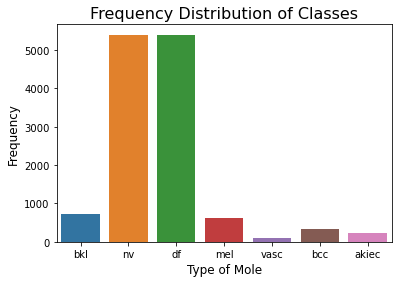

In [256]:
sns.countplot(x = 'dx', data = y)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

### Splitting the dataset

In [257]:
#Splitting dataset
#Reference https://www.youtube.com/watch?v=nuakBf3rBmw, https://www.kaggle.com/code/dhruv1234/ham10000-skin-disease-classification/notebook

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [258]:
#create aparts datasets after splitting
train = pd.concat([X_train, y_train], axis = 1)
val = pd.concat([X_val, y_val], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [259]:
encoder = LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx'])
test['label'] = name_as_indexes_test

In [260]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_test = encoder.transform(val['dx'])
val['label'] = name_as_indexes_test

In [261]:
test.head()

,image_name,lesion_id,dx,label
5173,ISIC_0028300.jpg,HAM_0004092,nv,5
9590,ISIC_0025911.jpg,HAM_0004648,df,3
1355,ISIC_0027560.jpg,HAM_0003885,mel,4
6114,ISIC_0034069.jpg,HAM_0003441,nv,5
3519,ISIC_0024719.jpg,HAM_0007154,nv,5


In [262]:
val.head()

,image_name,lesion_id,dx,label
5446,ISIC_0026061.jpg,HAM_0001973,nv,5
12747,ISIC_0030870.jpg,HAM_0006707,df,3
3892,ISIC_0029586.jpg,HAM_0003864,nv,5
7908,ISIC_0031799.jpg,HAM_0003348,df,3
6278,ISIC_0032021.jpg,HAM_0000335,nv,5


In [263]:
train.shape

(8192, 3)

In [264]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, 
                                     zoom_range = 0.1,
                                     width_shift_range=0.0, height_shift_range=0.00
)

In [265]:
#train_data = train_generator.flow_from_dataframe(dataframe=train, x_col='image_name', y_col="dx", batch_size=32, directory=path, shuffle =True, class_mode="categorical", target_size=(224,224), subset="training")
train_data = train_generator.flow_from_dataframe(dataframe=train, x_col='image_name', y_col="dx", batch_size=16, directory=path, shuffle =True, class_mode="categorical", target_size=(224,224), subset="training")

Found 8192 validated image filenames belonging to 7 classes.


In [266]:
for t in train_data: 
    print(t)
    break

(array([[[[0.09411766, 0.05490196, 0.08627451],
         [0.09411766, 0.05490196, 0.08627451],
         [0.09411766, 0.05490196, 0.08627451],
         ...,
         [0.14297467, 0.09019608, 0.11764707],
         [0.1434901 , 0.09019608, 0.11764707],
         [0.14400555, 0.09019608, 0.11764707]],

        [[0.09411766, 0.05490196, 0.08627451],
         [0.09411766, 0.05490196, 0.08627451],
         [0.09411766, 0.05490196, 0.08627451],
         ...,
         [0.14901961, 0.09019608, 0.11764707],
         [0.14901961, 0.09019608, 0.11764707],
         [0.14901961, 0.09019608, 0.11764707]],

        [[0.09411766, 0.05490196, 0.08627451],
         [0.09411766, 0.05490196, 0.08627451],
         [0.09411766, 0.05490196, 0.08627451],
         ...,
         [0.1467613 , 0.08944331, 0.11689429],
         [0.14598814, 0.0891856 , 0.11663657],
         [0.14521497, 0.08892787, 0.11637885]],

        ...,

        [[0.13333334, 0.08627451, 0.13333334],
         [0.13333334, 0.08627451, 0.13333334

In [267]:
print('Type of classes:' ,train_data.class_indices)
print('Number of samples: ',train_data.samples)
print('Number of class: ',len(train_data.class_indices))
print('Number of samples per class: ', int(train_data.samples/len(train_data.class_indices)))

Type of classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Number of samples:  8192
Number of class:  7
Number of samples per class:  1170


In [268]:
train_data.image_shape

(224, 224, 3)

In [269]:
test_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, 
                                     zoom_range = 0.1,
                                     width_shift_range=0.0, height_shift_range=0.02
)


In [270]:
test_data = test_generator.flow_from_dataframe(dataframe=test, x_col='image_name', y_col="dx", batch_size=64, directory=path, shuffle=False, class_mode="categorical", target_size=(224,224))

Found 2560 validated image filenames belonging to 7 classes.


In [271]:
test_data.image_shape

(224, 224, 3)

In [272]:
test_data

In [273]:
print('Type of classes:' ,test_data.class_indices)
print('Number of samples: ',test_data.samples)
print('Number of class: ',len(test_data.class_indices))
print('Number of samples per class: ', int(test_data.samples/len(test_data.class_indices)))

Type of classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Number of samples:  2560
Number of class:  7
Number of samples per class:  365


In [274]:
val_data = test_generator.flow_from_dataframe(dataframe=val, x_col='image_name', y_col="dx", batch_size=64, directory=path, shuffle=True, class_mode="categorical", target_size=(224,224))

Found 2048 validated image filenames belonging to 7 classes.


In [275]:
val_data.image_shape

(224, 224, 3)

In [276]:
print('Type of classes:' ,val_data.class_indices)
print('Number of samples: ',val_data.samples)
print('Number of class: ',len(val_data.class_indices))
print('Number of samples per class: ', int(val_data.samples/len(val_data.class_indices)))

Type of classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Number of samples:  2048
Number of class:  7
Number of samples per class:  292


### Showcase some of the training images

In [277]:
def plot_images(img_array):
    fig, axes = plt.subplots(1,5, figsize=(25,25))
    axes = axes.flatten()
    for img, ax in zip(img_array,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

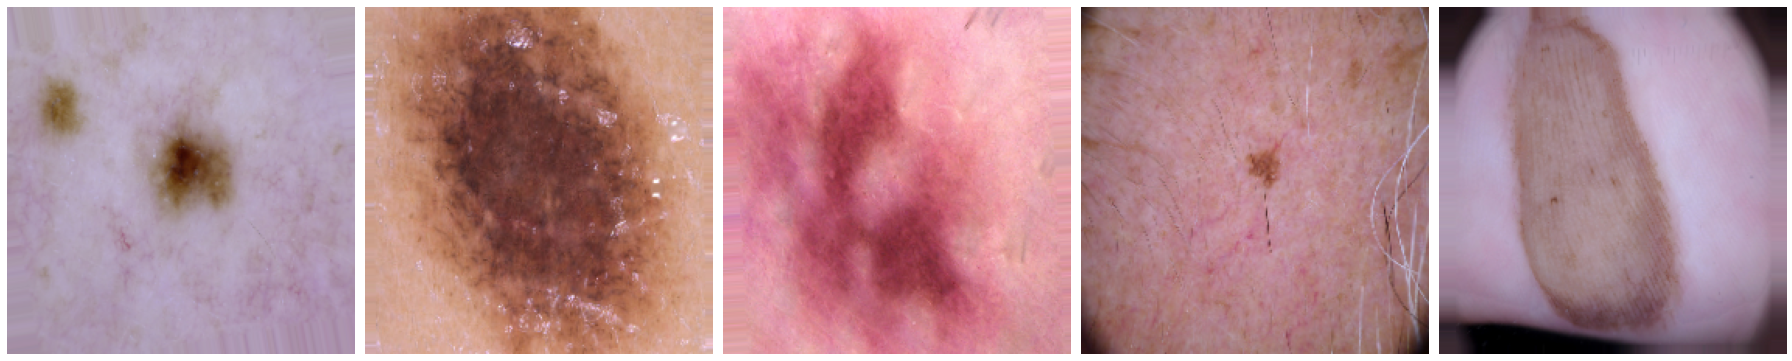

In [278]:
sample_train_images, _ = next(train_data)
plot_images(sample_train_images[:5])

In [279]:
#Using model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))


In [280]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
#Output layer must match the different outputs from our labels, in this case 7
model.add(Dense(7,activation='sigmoid'))

In [281]:
#Reference https://www.kaggle.com/code/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe/notebook
# We'll stop training if no improvement after some epochs
earlystopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
# Save the best model during the traning
checkpointer = ModelCheckpoint('./model/best_model1.h5'
                                        ,monitor='val_accuracy'
                                        ,verbose=1
                                        ,save_best_only=True
                                        ,save_weights_only=True)
history1 = History()

In [282]:
#learning_control = ReduceLROnPlateau(monitor='val_acc',patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [283]:
#Defining metrics
# METRICS = [
#       metrics.TruePositives(name='tp'),
#       metrics.FalsePositives(name='fp'),
#       metrics.TrueNegatives(name='tn'),
#       metrics.FalseNegatives(name='fn'), 
#       metrics.CategoricalAccuracy(name='accuracy'),
#       metrics.CategoricalAccuracy(name='val_acc'),
#       metrics.Precision(name='precision'),
#       metrics.Recall(name='recall'),
#       metrics.AUC(name='auc'),
#       metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]

In [284]:
sgd = SGD(learning_rate=0.01,clipvalue=0.5)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['accuracy'])

In [285]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 16)          184336    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 16)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [286]:
history=model.fit(train_data,batch_size=128, epochs=5, validation_data=val_data ,callbacks=[earlystopper, checkpointer, reduce_lr, history1])


Epoch 1/5
512/512 [==============================] - ETA: 0s - loss: 0.8705 - accuracy: 0.7421
Epoch 1: val_accuracy improved from -inf to 0.40869, saving model to ./model\best_model1.h5
512/512 [==============================] - 1021s 2s/step - loss: 0.8705 - accuracy: 0.7421 - val_loss: 4.1188 - val_accuracy: 0.4087 - lr: 0.0100
Epoch 2/5
512/512 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.8308
Epoch 2: val_accuracy improved from 0.40869 to 0.48975, saving model to ./model\best_model1.h5
512/512 [==============================] - 1075s 2s/step - loss: 0.5328 - accuracy: 0.8308 - val_loss: 2.1776 - val_accuracy: 0.4897 - lr: 0.0100
Epoch 3/5
512/512 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.8390
Epoch 3: val_accuracy improved from 0.48975 to 0.52344, saving model to ./model\best_model1.h5
512/512 [==============================] - 998s 2s/step - loss: 0.4524 - accuracy: 0.8390 - val_loss: 6.3506 - val_accuracy: 0.5234 - lr: 0.0

In [287]:
#Get the best saved weights
model.load_weights('./model/best_model1.h5')

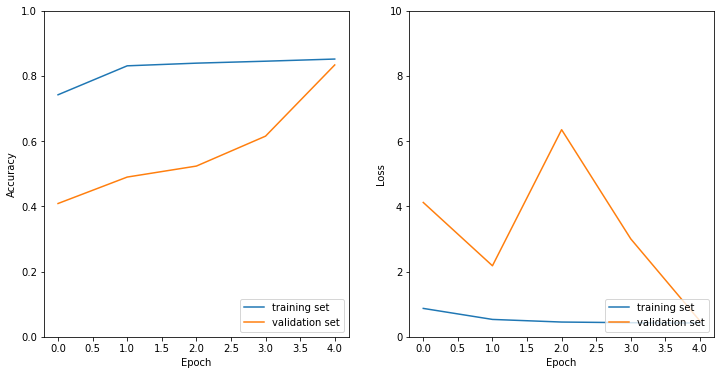

In [288]:
import tensorflow

def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    #plt.title("Model Accuracy")
    #axs[0].plt.title('Model Accuracy')
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])
    
    #plt.title("Model Loss")
    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [290]:
loss, acc = model.evaluate(test_data, verbose=0)
model.evaluate(test_data, verbose=2)

print('Test loss:', loss)
print('Test accuracy:', acc)

40/40 - 95s - loss: 0.4721 - accuracy: 0.8352 - 95s/epoch - 2s/step
Test loss: 0.46180933713912964
Test accuracy: 0.837109386920929


In [291]:
loss, acc = model.evaluate(val_data, verbose=2)
print('Validation loss:', loss)
print('Validation accuracy:', acc)

32/32 - 63s - loss: 0.4912 - accuracy: 0.8345 - 63s/epoch - 2s/step
Validation loss: 0.49119430780410767
Validation accuracy: 0.83447265625


In [294]:
history.history

{'loss': [0.8704999089241028,
  0.5327910780906677,
  0.45238348841667175,
  0.43229007720947266,
  0.4219953417778015],
 'accuracy': [0.7420654296875,
  0.830810546875,
  0.8389892578125,
  0.844970703125,
  0.8515625],
 'val_loss': [4.1187639236450195,
  2.177623748779297,
  6.350638389587402,
  3.001537799835205,
  0.4841225743293762],
 'val_accuracy': [0.40869140625,
  0.48974609375,
  0.5234375,
  0.615234375,
  0.83349609375],
 'lr': [0.01, 0.01, 0.01, 0.01, 0.01]}

In [297]:
print('Loss is ' + str(history.history['loss'][4]))

Loss is 0.4219953417778015


In [298]:
print('Accuracy is ' + str(history.history['accuracy'][4]))

Accuracy is 0.8515625


In [300]:
#print('Precision is ' + str(history.history['precision'][4]))

In [383]:
#print('Recall is ' + str(history.history['recall'][4]))

In [301]:
model.save('./model/my_model.h5')

In [302]:
# Dictionary with different classes of moles:
#Reference: https://www.kaggle.com/code/dhruv1234/ham10000-skin-disease-classification/notebook
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

### Predicting Class Type

ISIC_0029347.jpg


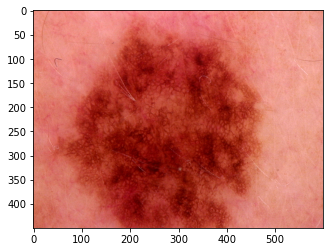

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0033428.jpg


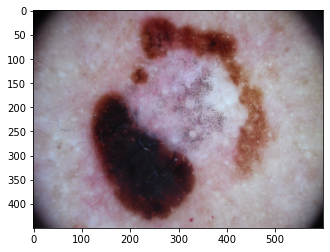

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0028166.jpg


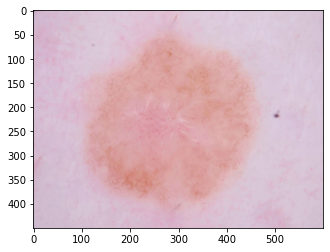

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0025101.jpg


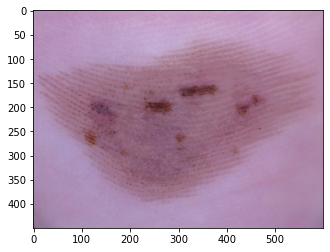

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0026475.jpg


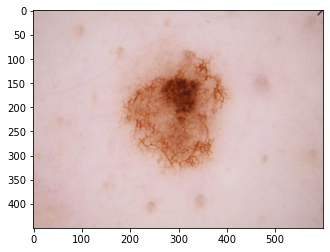

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0029701.jpg


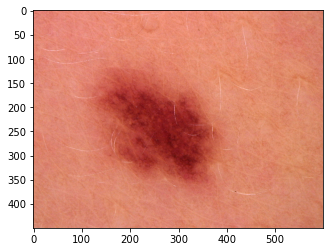

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0025533.jpg


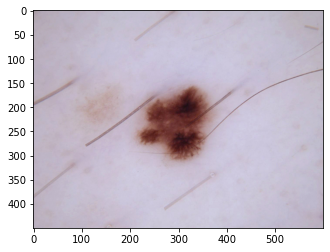

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0027843.jpg


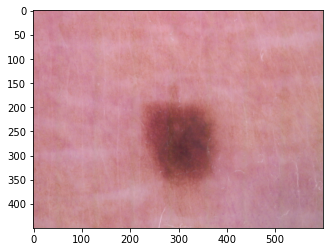

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0032770.jpg


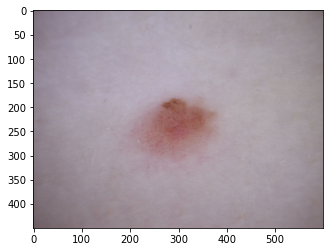

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0027013.jpg


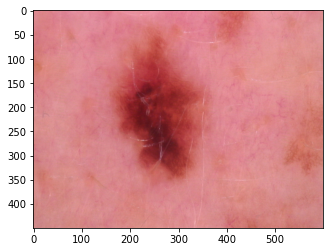

('vasc', ' pyogenic granulomas and hemorrhage')


In [308]:

for temp in range(0,10):
    img_name = random.choice(os.listdir(path))
    print(img_name)
    img = cv2.imread(os.path.join(path, img_name))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    img = cv2.resize(img, (224, 224))
    result = model.predict(img.reshape(1, 224, 224, 3))
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = classes[class_ind]
    print(class_name)
    

In [ ]:
#Classification Report

#print(classification_report(classes, preds_cls.astype(int)))